In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga, gc, utils

In [2]:
second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# # Load in the filters from the model
# with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
#     filters = np.load(f)


### Get the violin plots to show maximum activation difference

In [3]:
num_patients = 2

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, 
                                                     max_events=max_timesteps-1, 
                                                     max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_act_metric_per_feat(model, num_filters, num_patients, 
                                                                             pat_df, max_event_codes, hip_or_knee,
                                                                             'max')


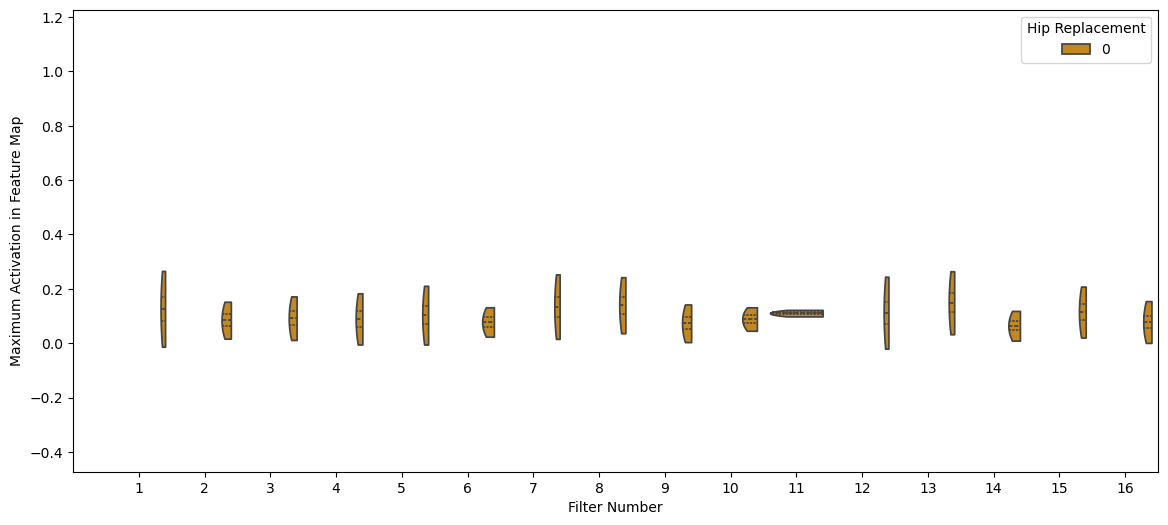

In [4]:
plot_feature_value.violin_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

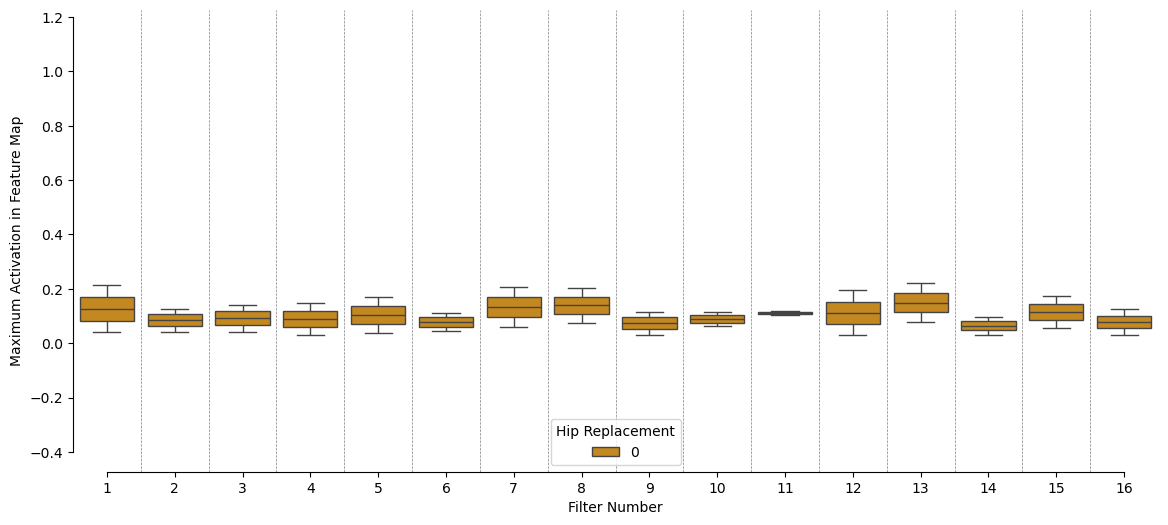

In [5]:
plot_feature_value.max_act_box_plots(filt_nums, max_w_filt_lst, replacement_true_lst)

### Calculate the strongest difference in activation between the patient and control participants

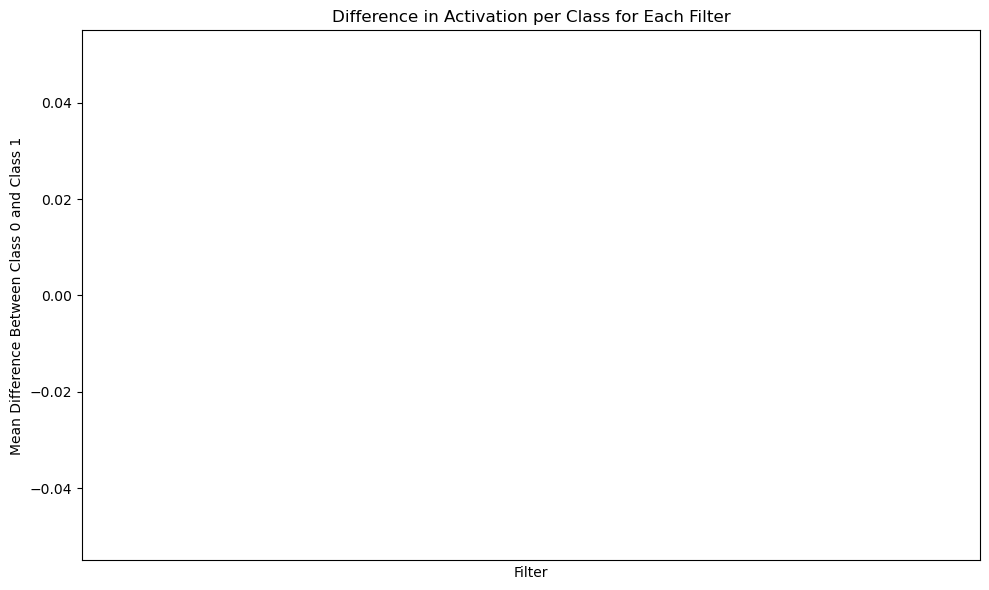

In [6]:
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

### Activation mapping - timesteps

In [7]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)
logits = model(input_4d, demo_tensor, training=False)



### Feature map plots

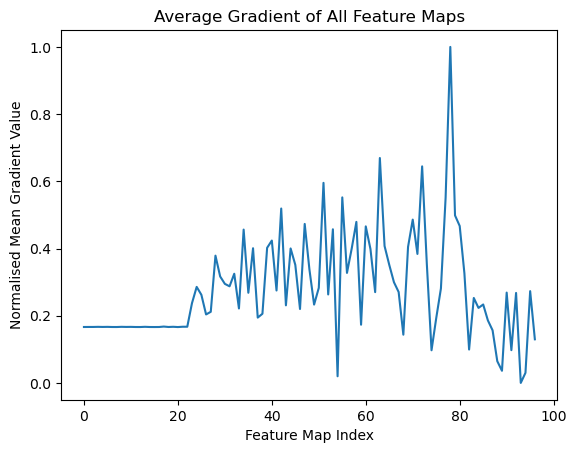

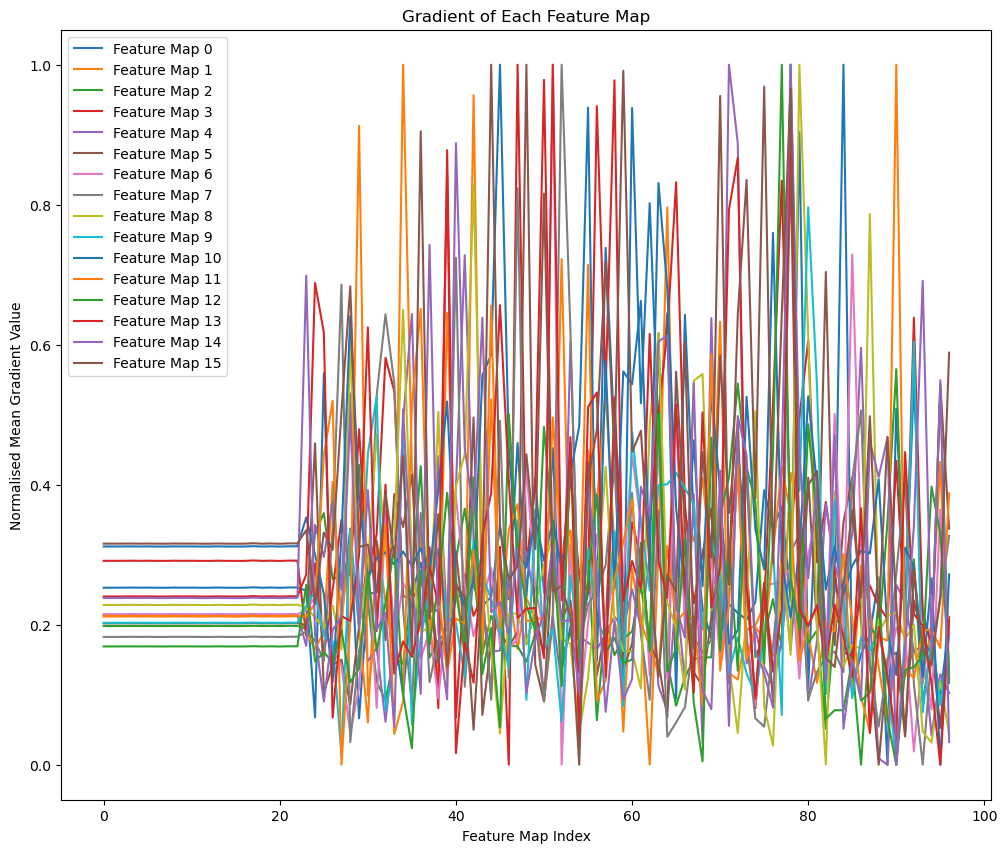

In [8]:
# PLOT THE FEATURE MAPS
norm_features = plot_feature_value.plot_ave_grad_all_f_maps(model.f_map_branch1)

plot_feature_value.plot_indv_grad_f_maps(model.f_map_branch1)

### Graph plots

In [9]:
# Get the entire patient's history in a DataFrame
edges_df = graph_plot.create_edges_df_gc(dense_tensor)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)


In [10]:
weighted_f_map = ga.choose_feat_map(model, 'mean', mean_activation_df)

# map the timesteps to their relevant features
timestep_ave_w_df = gc.calc_timestep_weights(1, filter_size, weighted_f_map, max_timesteps)


# map the timestep values to colour the edges of the graph
read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_w_df)

edge_pos_df = gc.create_edge_pos_df(edges_df, pos_df)

gc.plot_gradcam_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, 'all_filters_time_act', html_open=False)


In [11]:
summ_stat_type = 'mean'
# for max set summ_stat_type as 'single' and then add feat_map_num=30 to ga.choose_feat_map

sensitivity_list = []
for pat in range(2):
    input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0) # REPLACE WITH CV_PATIENTS AND PAT NUMBER
    dense_tensor = tf.sparse.to_dense(input_3d)
    dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
    dense_tensor = np.flip(dense_tensor, axis=0)
    logits = model(input_4d, demo_tensor, training=False)

    edges_df = graph_plot.create_edges_df_gc(dense_tensor)

    # Get the node positions for the graph
    pos_df = graph_plot.create_position_df_gc(edges_df)
    pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
    pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

    weighted_f_map = ga.choose_feat_map(model, summ_stat_type)

    # map the timesteps to their relevant features
    timestep_ave_w_df = gc.calc_timestep_weights(1, filter_size, weighted_f_map, max_timesteps)


    # map the timestep values to colour the edges of the graph
    read_code_pos_df = gc.map_read_code_labels(pos_df, read_code_map_df, timestep_ave_w_df)

    #edge_pos_df = gc.create_edge_pos_df(edges_df, pos_df)
    v_mod_list, v_orig_list = [], []
    for i in range(2):
        input_3d, input_4d, demo_tensor, outcome, outcome_bin, visit_num = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0, add_p_node=True) # REPLACE WITH CV_PATIENTS AND PAT NUMBER
        dense_tensor = tf.sparse.to_dense(input_3d)
        dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
        dense_tensor_p = np.flip(dense_tensor, axis=0)
        logits = model(input_4d, demo_tensor, training=False)

        p_edges_df = graph_plot.create_edges_df_gc(dense_tensor_p)

        p_pos_df = graph_plot.create_position_df_gc(p_edges_df)
        p_pos_list = graph_plot.generate_pos_sequence(p_pos_df['max_codes_per_visit'].max())
        p_pos_df = graph_plot.map_y_coord_to_node(p_pos_df, p_pos_list)

        p_weighted_f_map = ga.choose_feat_map(model, summ_stat_type)

        p_timestep_ave_w_df = gc.calc_timestep_weights(1, filter_size, p_weighted_f_map, max_timesteps)

        p_read_code_pos_df = gc.map_read_code_labels(p_pos_df, read_code_map_df, p_timestep_ave_w_df)

        # get the difference in the percentage influence on the timestep with and without the psuedo node
        mod_visit_infl = p_read_code_pos_df[p_read_code_pos_df['x']==visit_num]['perc_timestep_infl']

        v_mod = mod_visit_infl.iloc[0]

        orig_visit_infl = read_code_pos_df[read_code_pos_df['x']==visit_num]['perc_timestep_infl']
        v_orig = orig_visit_infl.iloc[0]

        v_mod_list.append(v_mod)
        v_orig_list.append(v_orig)



    l1_norm = np.sum(np.abs(np.array(v_mod_list) - np.array(v_orig_list)))
    ave_l1_norm = l1_norm / 50
    #print(ave_l1_norm)
    sensitivity_list.append(ave_l1_norm)
print(f"Sensitivity mean +- std: {np.mean(sensitivity_list)}$\pm${np.std(sensitivity_list)}")
    

Sensitivity mean +- std: 0.03630190134048462$\pm$0.011423184871673583
